<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span><ul class="toc-item"><li><span><a href="#OS" data-toc-modified-id="OS-4.1">OS</a></span><ul class="toc-item"><li><span><a href="#Cox" data-toc-modified-id="Cox-4.1.1">Cox</a></span></li></ul></li><li><span><a href="#PFS" data-toc-modified-id="PFS-4.2">PFS</a></span><ul class="toc-item"><li><span><a href="#Cox" data-toc-modified-id="Cox-4.2.1">Cox</a></span></li></ul></li></ul></li><li><span><a href="#Gender" data-toc-modified-id="Gender-5">Gender</a></span></li><li><span><a href="#Ethnicity" data-toc-modified-id="Ethnicity-6">Ethnicity</a></span></li><li><span><a href="#Age" data-toc-modified-id="Age-7">Age</a></span></li></ul></div>

# Dependencies

In [1]:
options(scipen = 999)

In [38]:
library(survival)
library(survminer)
library(forestmodel)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

In [3]:
source("~/OneDrive - UHN/R_src/ggplot2_theme.R")
source("~/OneDrive - UHN/R_src/color_schemes.R")

In [4]:
KM_plot <- function(metadata, fit_model, col, title, ylab, legendlabs){
    kmplot <- ggsurvplot(fit_model, data = metadata,
                         palette = as.vector(col),conf.int=FALSE, 
                         xlim = c(0,5000),break.x.by = 1000,
                         #Risk table
                         risk.table = TRUE,
                         # pvalue
                         pval = TRUE, pval.size = 10, pval.coord = c(200, 0.1),
                         # legend
                         legend.title="", font.legend = 25, legend.labs = legendlabs, legend = c(0.9, 0.9),
                         # fonts
                         font.main = 30, font.x = 30, font.y = 30, font.tickslab = 30, 
                         # titles
                         title = title, xlab = "Time (days)", ylab = ylab) 
    
    kmplot$table <- ggrisktable(fit_model, data = metadata, 
                                color = "strata", palette = as.vector(col),
                                fontsize = 10, risk.table.title = "",
                                xlim = c(0,5000),break.time.by = 1000,
                                y.text = TRUE, ylab = "",  xlab = "",legend.labs = legendlabs,
                                tables.theme = theme_cleantable(), font.tickslab = 20)

    return(kmplot)
}

In [5]:
stacked_plots <- function(freqtab, var1, var2){

    myplot <- ggplot(freqtab, aes(fill = eval(as.name(var2)), y = freq, x = eval(as.name(var1)))) + 
    geom_bar(position="stack", stat="identity") +
 #   scale_fill_brewer(palette = color) + 
    theme(axis.title.y = element_text(size = 45),
          axis.title.x = element_blank(),
          axis.line = element_line(color = "black"),
          axis.text.x = element_text(size = 45,angle = 45, hjust = 1, color = "black"),
          axis.text.y = element_text(size = 45, color = "black")) +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          plot.background = element_rect(fill = "transparent", colour = NA),
          plot.title = element_text(size = 45)) +
    theme(legend.position = "right", legend.direction="vertical",
          legend.text = element_text(size = 45),
          legend.key.height= unit(2, 'cm'),
          legend.key.width= unit(2, 'cm'),
          legend.title = element_blank())
    
    return(myplot)
}

# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Manifests/"

# Main

In [132]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [133]:
metadata_IC$percread <- 8.0947988*exp(metadata_IC$ImmuneScore*0.0006267)

## OS

In [134]:
metadata_IC$vital_status <- as.numeric(as.character(metadata_IC$vital_status))

In [135]:
sfit <- survfit(Surv(days_to_death, vital_status)~ immune_cluster, data=metadata_IC)
IC_KM_OS <- KM_plot(metadata_IC, sfit, cluster_col, "Immune cluster", "Overall survival", names(cluster_col))

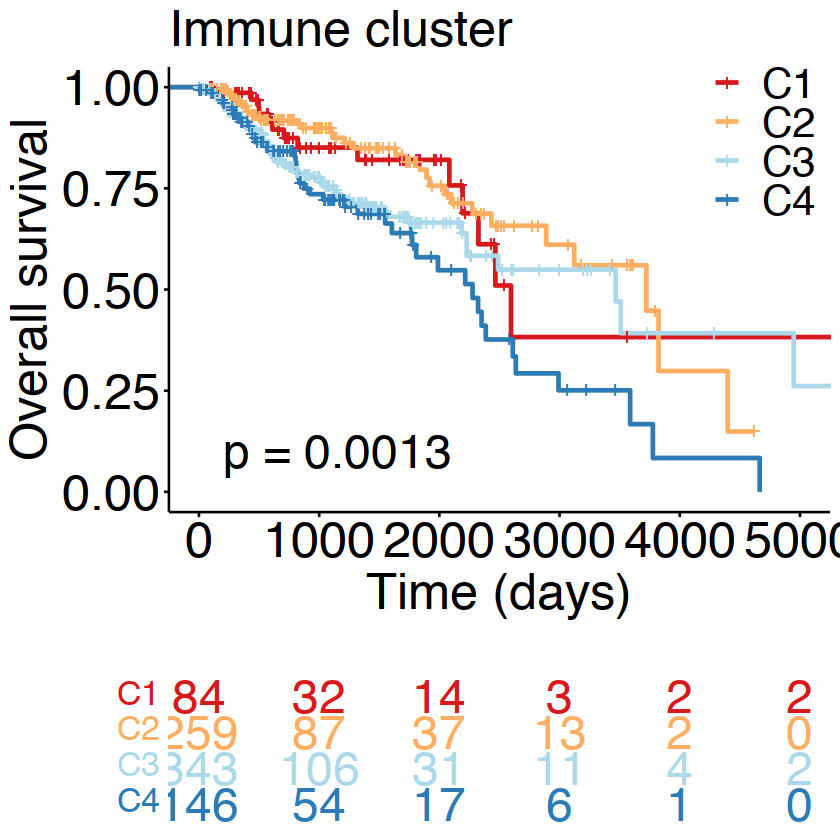

In [136]:
IC_KM_OS

In [137]:
pdf(paste0(plotpath, "IC_KM_OS.pdf"),
   width = 10, height = 12, onefile = F)

IC_KM_OS

dev.off()

pdf 
  2

In [138]:
# just to align colors to clusters according to the immunity paper
metadata_IC$CRI_cluster <- factor(metadata_IC$CRI_cluster, levels = names(cri_col))

In [139]:
table(metadata_IC$CRI_cluster)


        Wound Healing    IFN-gamma dominant          Inflammatory 
                   64                    26                   148 
  Lymphocyte depleted Immunologically quiet      TGFbeta dominant 
                  554                   110                     6 

In [140]:
sfit <- survfit(Surv(days_to_death, vital_status)~ CRI_cluster, data=metadata_IC)
CRI_KM_OS <- KM_plot(metadata_IC, sfit, cri_col, "CRI-iAtlas clusters", "Overall survival", names(cri_col))

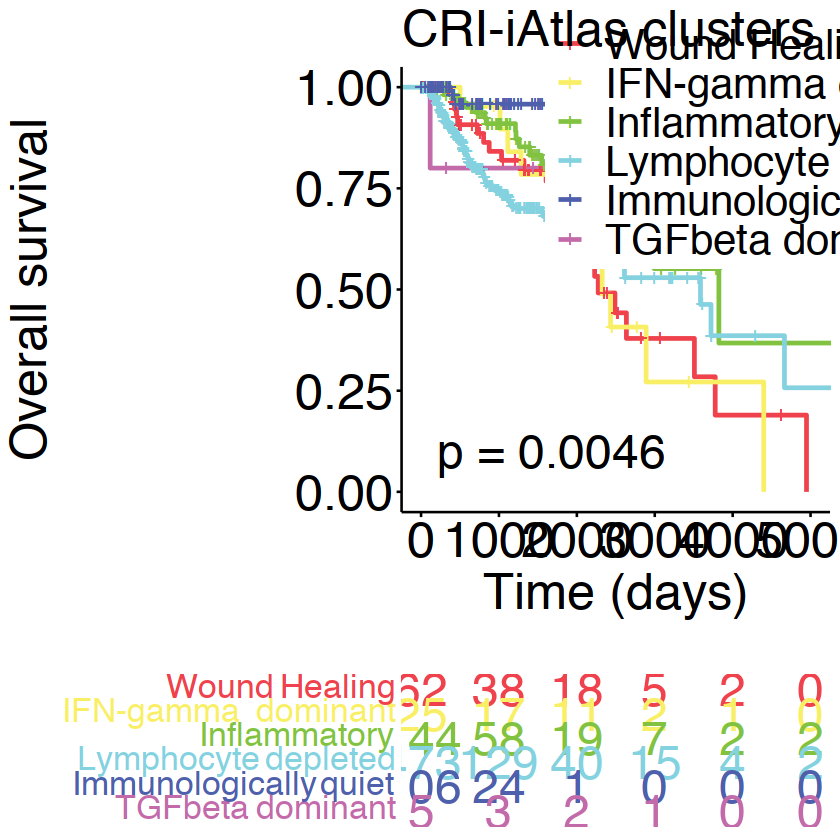

In [141]:
CRI_KM_OS

In [142]:
pdf(paste0(plotpath, "CRI_KM_OS.pdf"),
   width = 10, height = 12, onefile = F)

CRI_KM_OS

dev.off()

pdf 
  2

### Cox

for(i in c("NBL", "pedHGG", "MB", "EPN", "ATRT")){
    
    coxmodel <- coxph(Surv(days_to_death, vital_status)~ immune_cluster + tumour_subtype,
                      data= metadata_IC[metadata_IC$cohort == i,]) 
print(i)
print(summary(coxmodel))
    
}

In [155]:
coxmodel <- coxph(Surv(days_to_death, vital_status)~ immune_cluster + cohort + 
                  age_at_diagnosis + gender + ethnicity, data= metadata_IC) 

summary(coxmodel)

Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


Call:
coxph(formula = Surv(days_to_death, vital_status) ~ immune_cluster + 
    cohort + age_at_diagnosis + gender + ethnicity, data = metadata_IC)

  n= 693, number of events= 150 
   (232 observations deleted due to missingness)

                                                          coef
immune_clusterC2                        0.14527386593655317037
immune_clusterC3                        0.39920078170500156167
immune_clusterC4                        0.61975363530523452926
cohortCP                               -1.84108014217308402216
cohortCPH                              -2.39845061185241092971
cohortEPN                              -2.28294088067795497565
cohortETMR                            -39.11065879927711108621
cohortMB                               -1.68825485868334657091
cohortMNG                             -15.63689710073783345479
cohortNBL                             -15.47764600516279109854
cohortNFB                              -1.06890656878476386638
cohortpedHGG

In [19]:
summary_cox <- summary(coxmodel)

In [20]:
mycox <- cbind(summary_cox$coefficients, summary_cox$conf.int[,c("lower .95","upper .95")])

In [21]:
rownames(mycox) <- gsub("immune_cluster", "", rownames(mycox))
rownames(mycox) <- gsub("cohort", "", rownames(mycox))

In [22]:
write.csv(mycox, file = paste0(datapath,"Cox/IC_OS_Cox_cohort.csv"))

In [23]:
xlsx::write.xlsx(mycox, file = "~/OneDrive - UHN//Documents/Manuscripts/IPD/v9/TableS5.xlsx")

## PFS

In [144]:
metadata_IC$recurrence <- as.numeric(as.character(metadata_IC$recurrence))

In [145]:
sfit <- survfit(Surv(days_to_progress, recurrence)~ immune_cluster, data=metadata_IC)
IC_KM_PFS <- KM_plot(metadata_IC, sfit, cluster_col, "Immune clusters", "Progression-free survival", names(cluster_col))

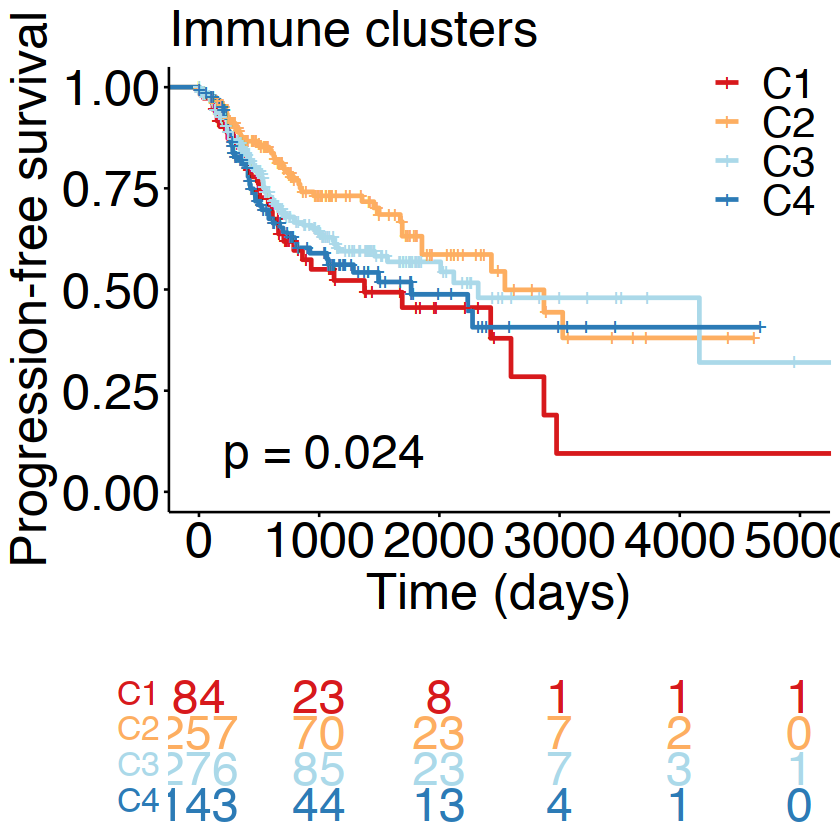

In [146]:
IC_KM_PFS

In [147]:
pdf(paste0(plotpath, "IC_KM_PFS.pdf"),
   width = 10, height = 12, onefile = F)

IC_KM_PFS

dev.off()

pdf 
  2

In [148]:
sfit <- survfit(Surv(days_to_progress, recurrence)~ CRI_cluster, data=metadata_IC)
CRI_KM_PFS <- KM_plot(metadata_IC, sfit, cri_col, "CRI-iAtlas clusters", "Progression-free survival", names(cri_col))

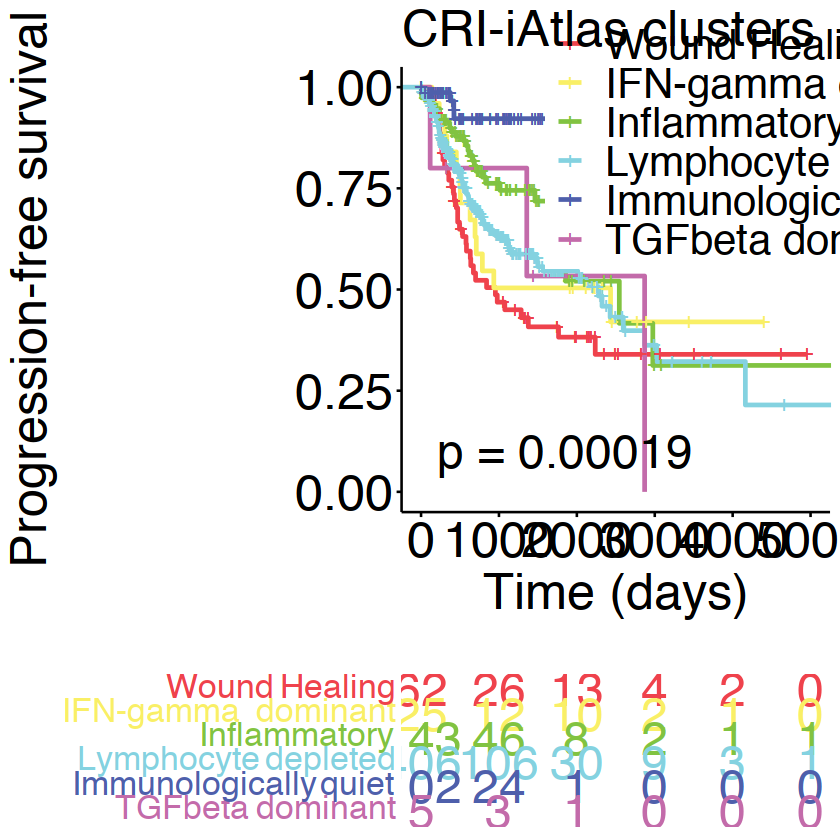

In [149]:
CRI_KM_PFS

In [150]:
pdf(paste0(plotpath, "CRI_KM_PFS.pdf"),
   width = 10, height = 12, onefile = F)

CRI_KM_PFS

dev.off()

pdf 
  2

### Cox

In [151]:
metadata_IC$immune_cluster <- factor(metadata_IC$immune_cluster,
                                    levels = c("C1", "C2", "C3", "C4"))

for(i in c("NBL", "pedHGG", "pedLGG","MB", "EPN", "ATRT")){
    
    coxmodel <- coxph(Surv(days_to_progress, recurrence)~ immune_cluster 
                       ,
                      data= metadata_IC[metadata_IC$cohort == i,]) 
print(i)
print(summary(coxmodel))
    
}

In [154]:
coxmodel <- coxph(Surv(days_to_progress, recurrence) ~ immune_cluster + cohort + 
                  age_at_diagnosis + gender + ethnicity, data= metadata_IC)
summary(coxmodel)

Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  17,21 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(days_to_progress, recurrence) ~ immune_cluster + 
    cohort + age_at_diagnosis + gender + ethnicity, data = metadata_IC)

  n= 692, number of events= 204 
   (233 observations deleted due to missingness)

                                              coef          exp(coef)
immune_clusterC2                      -0.420688358        0.656594692
immune_clusterC3                      -0.325345970        0.722277424
immune_clusterC4                      -0.001034731        0.998965805
cohortCP                              -1.817630696        0.162410094
cohortCPH                             -2.706646959        0.066760282
cohortEPN                             -1.136257499        0.321018187
cohortETMR                             3.120088823       22.648391248
cohortMB                              -1.370375522        0.254011555
cohortMNG                             -0.602686026        0.547339492
cohortNBL                              1.785092322        5.9601301

In [33]:
summary_cox <- summary(coxmodel)

In [34]:
mycox <- cbind(summary_cox$coefficients, summary_cox$conf.int[,c("lower .95","upper .95")])

In [35]:
rownames(mycox) <- gsub("immune_cluster", "", rownames(mycox))
rownames(mycox) <- gsub("cohort", "", rownames(mycox))

In [36]:
write.csv(mycox, file = paste0(datapath,"Cox/IC_PFS_Cox_cohort.csv"))

In [37]:
xlsx::write.xlsx(mycox, file = "~/OneDrive - UHN//Documents/Manuscripts/IPD/v9/TableS6.xlsx")

# Gender

In [51]:
metadata_gender <- metadata_IC[!is.na(metadata_IC$gender),]
metadata_gender <- metadata_gender[metadata_gender$gender != "Unknown",]

In [96]:
table(metadata_gender$gender, metadata_gender$immune_cluster)

        
          C1  C2  C3  C4
  Female  44 138 169  57
  Male    46 140 222 105

In [52]:
freqtab <- metadata_gender %>% group_by(cohort,gender) %>%
    summarise(n = n()) %>% mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'cohort'. You can override using the `.groups` argument.



In [53]:
females <- freqtab[ freqtab$gender == "Female",]
females <- females[order(females$freq),]

In [54]:
freqtab$cohort <- factor(freqtab$cohort, levels = females$cohort)

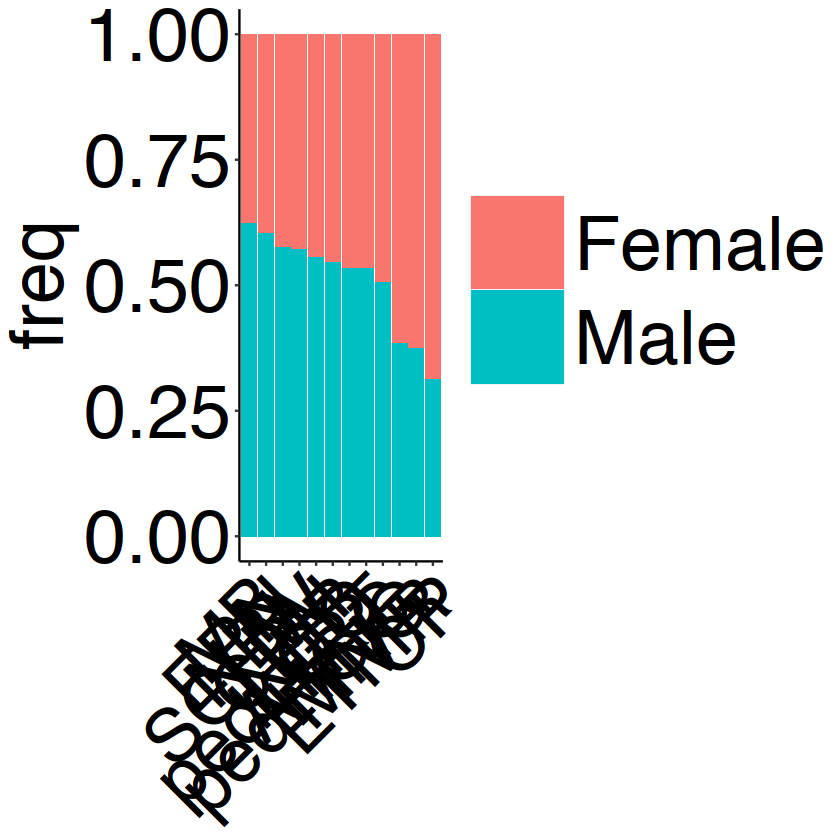

In [55]:
stacked_plots(freqtab, "cohort", "gender")

In [56]:
pdf(paste0(plotpath, "gender_cohort_plot.pdf"),
   width = 20, height = 10, onefile = F)


stacked_plots(freqtab, "cohort", "gender")

dev.off()

pdf 
  2

In [57]:
freqtab <- metadata_gender %>% group_by(immune_cluster,gender) %>%
    summarise(n = n()) %>% mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'immune_cluster'. You can override using the `.groups` argument.



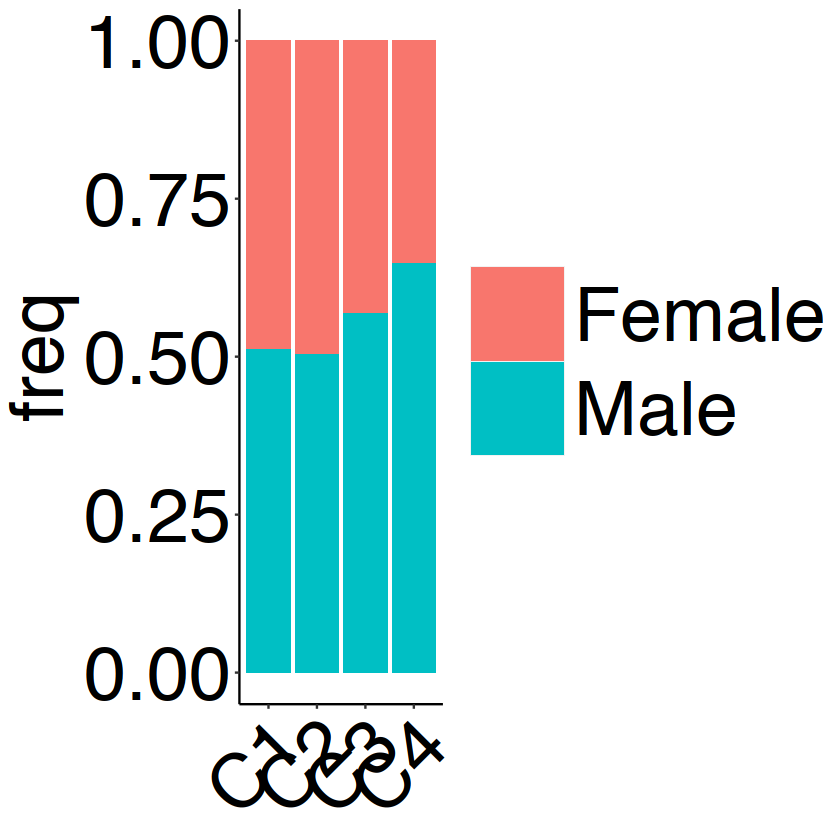

In [58]:
stacked_plots(freqtab, "immune_cluster", "gender")

In [59]:
pdf(paste0(plotpath, "gender_IC_plot.pdf"),
   width = 12, height = 10, onefile = F)


stacked_plots(freqtab, "immune_cluster", "gender")

dev.off()

pdf 
  2

In [60]:
rms::lrm(gender ~ immune_cluster + cohort, data = metadata_gender)

Logistic Regression Model
 
 rms::lrm(formula = gender ~ immune_cluster + cohort, data = metadata_gender)
 
                       Model Likelihood    Discrimination    Rank Discrim.    
                             Ratio Test           Indexes          Indexes    
 Obs           921    LR chi2     19.39    R2       0.028    C       0.580    
  Female       408    d.f.           14    g        0.320    Dxy     0.159    
  Male         513    Pr(> chi2) 0.1506    gr       1.377    gamma   0.173    
 max |deriv| 3e-08                         gp       0.077    tau-a   0.079    
                                           Brier    0.242                     
 
                   Coef    S.E.   Wald Z Pr(>|Z|)
 Intercept         -0.0690 0.4127 -0.17  0.8672  
 immune_cluster=C2  0.0204 0.2553  0.08  0.9362  
 immune_cluster=C3  0.2441 0.2620  0.93  0.3516  
 immune_cluster=C4  0.5703 0.2922  1.95  0.0509  
 cohort=CP         -0.9747 0.6569 -1.48  0.1379  
 cohort=CPH         0.2474 0.5395  0.

# Ethnicity

In [63]:
table(metadata_IC$race, useNA = "always")


African   Asian   Other Unknown   White    <NA> 
     75      12     185      15     443     195 

In [64]:
metadata_race <- metadata_IC[!is.na(metadata_IC$race),]
metadata_race <- metadata_race[metadata_race$race != "Unknown",]

In [95]:
table(metadata_race$race, metadata_race$immune_cluster)

         
           C1  C2  C3  C4
  African  11  24  21  19
  Asian     1   2   7   2
  Other    22  55  71  37
  White    50 137 168  88

In [79]:
table(metadata_race$race, useNA = "always")


African   Asian   Other   White    <NA> 
     75      12     185     443       0 

In [85]:
freqtab <- metadata_race %>% group_by(cohort,race) %>%
    summarise(n = n()) %>% mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'cohort'. You can override using the `.groups` argument.



In [87]:
white <- freqtab[ freqtab$race == "White",]
white <- white[order(white$freq, decreasing = F),]

In [88]:
freqtab$cohort <- factor(freqtab$cohort, levels = white$cohort)

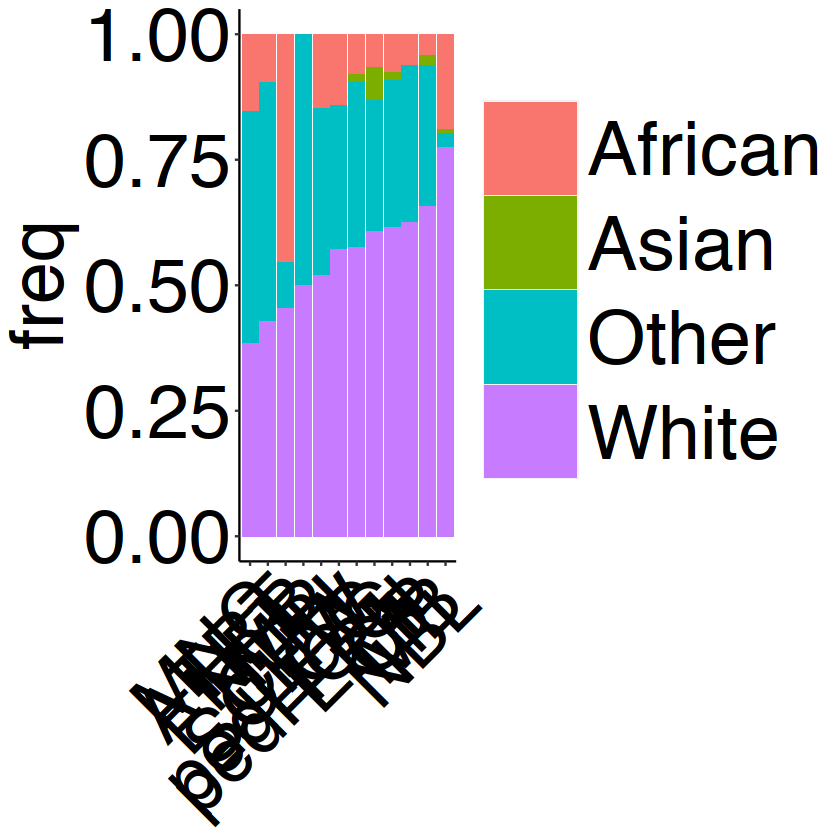

In [89]:
stacked_plots(freqtab, "cohort", "race")

In [90]:
pdf(paste0(plotpath, "race_cohort_plot.pdf"),
   width = 20, height = 10, onefile = F)


stacked_plots(freqtab, "cohort", "race")

dev.off()

pdf 
  2

In [91]:
freqtab <- metadata_race %>% group_by(immune_cluster,race) %>%
summarise(n = n()) %>% mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'immune_cluster'. You can override using the `.groups` argument.



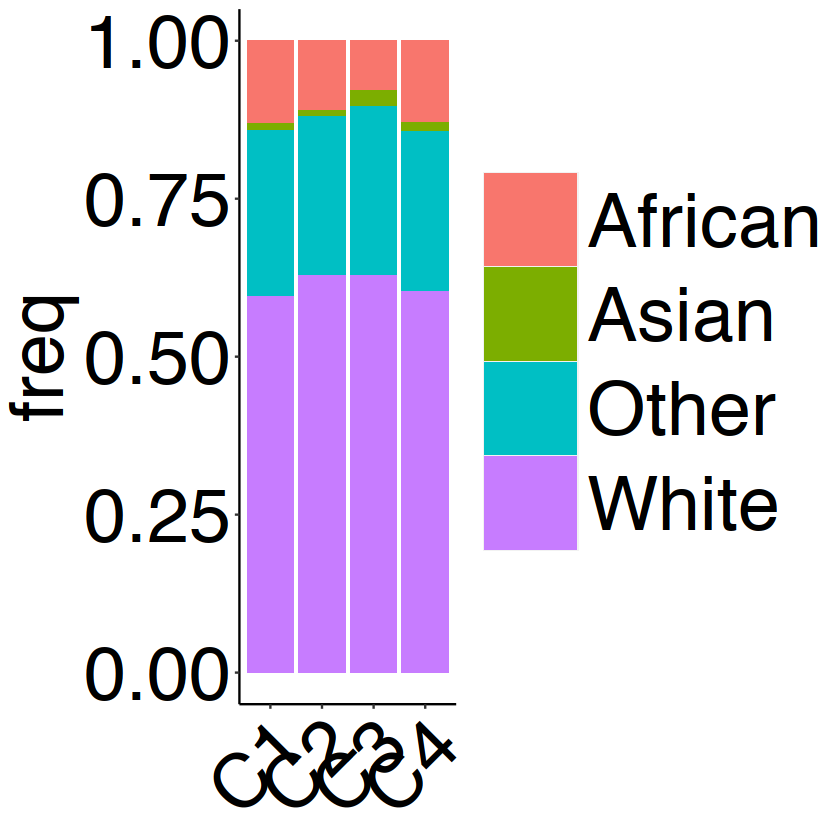

In [92]:
stacked_plots(freqtab, "immune_cluster", "race")

In [93]:
pdf(paste0(plotpath, "race_IC_plot.pdf"),
   width = 12, height = 10, onefile = F)


stacked_plots(freqtab, "immune_cluster", "race")

dev.off()

pdf 
  2

In [94]:
mantelhaen.test(metadata_race$race, 
                metadata_race$immune_cluster,
                metadata_race$cohort)


	Cochran-Mantel-Haenszel test

data:  metadata_race$race and metadata_race$immune_cluster and metadata_race$cohort
Cochran-Mantel-Haenszel M^2 = 5.9473, df = 9, p-value = 0.7452


# Age

In [103]:
metadata_IC$age_class[ metadata_IC$age_at_diagnosis == 2] <- "Infants"
metadata_IC$age_class[ metadata_IC$age_at_diagnosis == 12] <- "Children"
metadata_IC$age_class[ metadata_IC$age_at_diagnosis == 16] <- "Adolescents"
metadata_IC$age_class[ metadata_IC$age_at_diagnosis == 25] <- "Young adults"

In [108]:
metadata_age <- metadata_IC[!is.na(metadata_IC$age_at_diagnosis),]

In [109]:
table(metadata_age$age_class, metadata_age$immune_cluster)

              
                C1  C2  C3  C4
  Adolescents    9  39  59  13
  Adults         0   2   0   0
  Children      48 162 215  93
  Infants       18  46  80  52
  Young adults  13  28  37   5

In [79]:
table(metadata_race$race, useNA = "always")


African   Asian   Other   White    <NA> 
     75      12     185     443       0 

In [162]:
ageplot <- ggplot(data = metadata_age) + 
geom_boxplot(aes( x = immune_cluster, y = age_at_diagnosis), outlier.shape = NA, fill = "light grey") +
    theme(axis.title.y = element_text(size = 45),
          axis.title.x = element_blank(),
          axis.line = element_line(color = "black"),
          axis.text.x = element_text(size = 45, color = "black"),
          axis.text.y = element_text(size = 45, color = "black")) +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          plot.background = element_rect(fill = "transparent", colour = NA),
          plot.title = element_text(size = 45)) +
    theme(legend.position = "right", legend.direction="vertical",
          legend.text = element_text(size = 45),
          legend.key.height= unit(2, 'cm'),
          legend.key.width= unit(2, 'cm'),
          legend.title = element_blank())

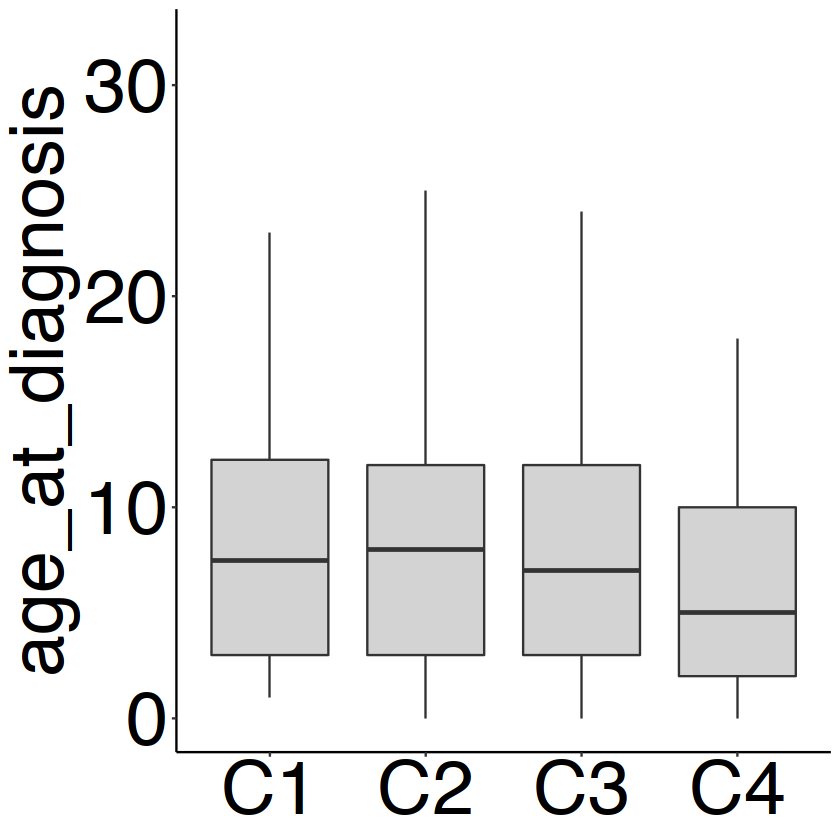

In [163]:
ageplot

In [164]:
pdf(paste0(plotpath, "age_IC_plot.pdf"),
   width = 12, height = 10, onefile = F)


ageplot

dev.off()

pdf 
  2

In [171]:
summary.lm(aov(age_at_diagnosis ~ immune_cluster + cohort, metadata_age))


Call:
aov(formula = age_at_diagnosis ~ immune_cluster + cohort, data = metadata_age)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.7367  -3.7663  -0.4735   3.0665  22.7997 

Coefficients:
                 Estimate Std. Error t value           Pr(>|t|)    
(Intercept)        2.8208     1.0712   2.633           0.008602 ** 
immune_clusterC2  -0.2207     0.6549  -0.337           0.736199    
immune_clusterC3  -0.5035     0.6710  -0.750           0.453262    
immune_clusterC4  -1.0907     0.7371  -1.480           0.139282    
cohortCP           5.4103     1.6282   3.323           0.000927 ***
cohortCPH          6.2038     1.3795   4.497 0.0000077892355773 ***
cohortEPN          6.2250     1.1462   5.431 0.0000000720828663 ***
cohortETMR         0.2026     1.9528   0.104           0.917398    
cohortMB           6.4787     1.0239   6.327 0.0000000003923358 ***
cohortMNG         10.2217     1.7137   5.965 0.0000000035107086 ***
cohortNBL          0.6528     1.0394   0.628   

In [175]:
mymed <- lapply(unique(metadata_age$cohort), function(x){
    median(metadata_age$age_at_diagnosis[ metadata_age$cohort == x])})

names(mymed) <- unique(metadata_age$cohort)

In [182]:
mymed[order(unlist(mymed))]

$NBL
[1] 2

$ATRT
[1] 2

$CP
[1] 3

$ETMR
[1] 3

$CPH
[1] 8

$pedLGG
[1] 8

$MB
[1] 8

$EPN
[1] 8

$pedHGG
[1] 9

$MNG
[1] 13

$NFB
[1] 17

$SCHW
[1] 18

In [183]:
metadata_age$cohort <- factor(metadata_age$cohort,
                             levels = names(mymed[order(unlist(mymed))]))

In [186]:
ageplot_cohort <- ggplot(data = metadata_age) + 
geom_boxplot(aes( x = cohort, y = age_at_diagnosis), outlier.shape = NA, fill = "light grey") +
    theme(axis.title.y = element_text(size = 45),
          axis.title.x = element_blank(),
          axis.line = element_line(color = "black"),
          axis.text.x = element_text(size = 45,angle = 45, hjust = 1, color = "black"),
          axis.text.y = element_text(size = 45, color = "black")) +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          plot.background = element_rect(fill = "transparent", colour = NA),
          plot.title = element_text(size = 45)) +
    theme(legend.position = "right", legend.direction="vertical",
          legend.text = element_text(size = 45),
          legend.key.height= unit(2, 'cm'),
          legend.key.width= unit(2, 'cm'),
          legend.title = element_blank())

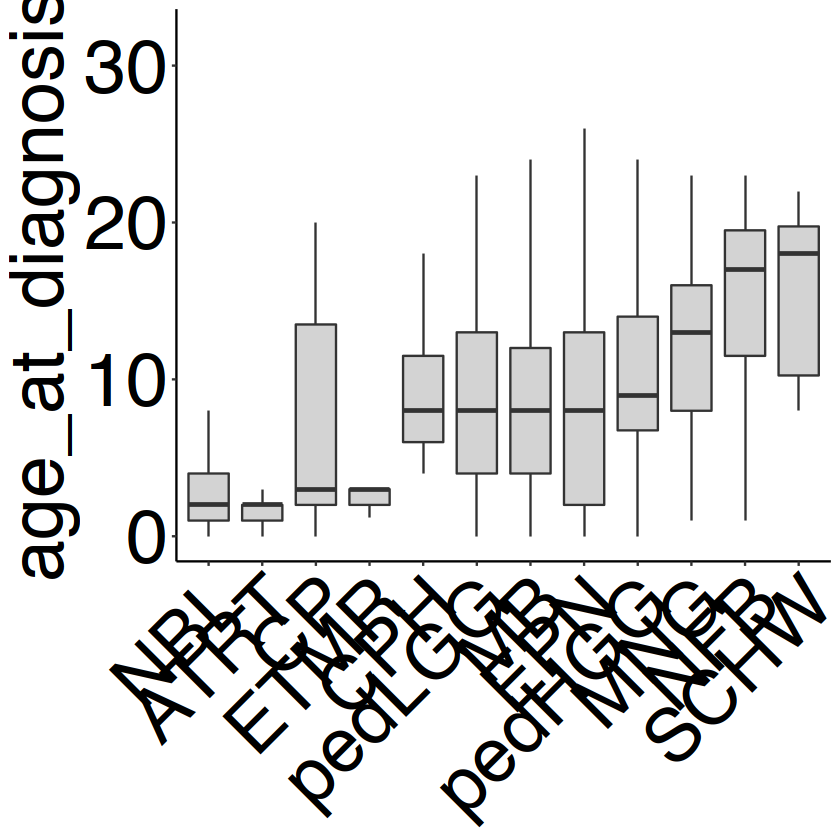

In [187]:
ageplot_cohort

In [188]:
pdf(paste0(plotpath, "age_cohort_boxplot.pdf"),
   width = 20, height = 10, onefile = F)


ageplot_cohort

dev.off()

pdf 
  2

In [110]:
freqtab <- metadata_age %>% group_by(cohort,age_class) %>%
    summarise(n = n()) %>% mutate(freq = n / sum(n)) 

`summarise()` has grouped output by 'cohort'. You can override using the `.groups` argument.



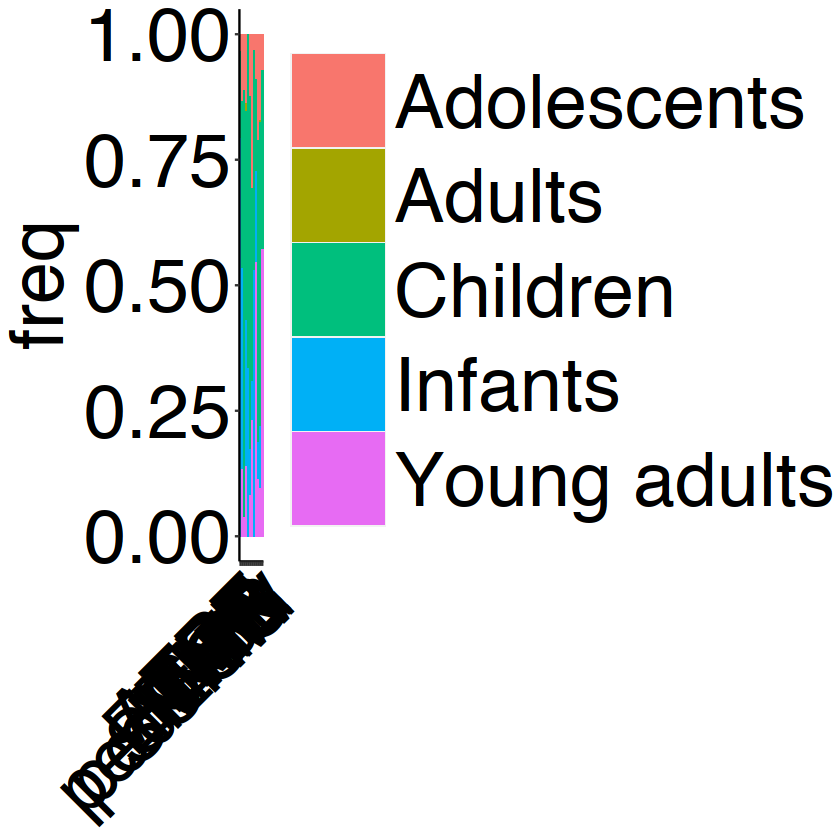

In [111]:
stacked_plots(freqtab, "cohort", "age_class")

In [112]:
pdf(paste0(plotpath, "age_class_cohort_plot.pdf"),
   width = 20, height = 10, onefile = F)


stacked_plots(freqtab, "cohort", "age_class")

dev.off()

pdf 
  2

In [127]:
metadata_age$immune_cluster <- factor(metadata_age$immune_cluster,
                                     levels = c("C1", "C2", "C3", "C4"))


Call:
aov(formula = age_at_diagnosis ~ immune_cluster, data = metadata_age)

Residuals:
   Min     1Q Median     3Q    Max 
-8.440 -5.093 -1.093  3.907 23.560 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)        8.6557     0.6152  14.069 < 0.0000000000000002 ***
immune_clusterC2  -0.2152     0.7062  -0.305              0.76059    
immune_clusterC3  -0.5626     0.6809  -0.826              0.40891    
immune_clusterC4  -2.4594     0.7634  -3.221              0.00132 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.771 on 915 degrees of freedom
Multiple R-squared:  0.0199,	Adjusted R-squared:  0.01668 
F-statistic: 6.191 on 3 and 915 DF,  p-value: 0.0003641


In [129]:
pairwise.t.test(metadata_age$age_at_diagnosis, metadata_age$immune_cluster)


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_age$age_at_diagnosis and metadata_age$immune_cluster 

   C1      C2      C3     
C2 1.00000 -       -      
C3 1.00000 1.00000 -      
C4 0.00528 0.00053 0.00222

P value adjustment method: holm 